### Реализация без подбора оптимального количества машин

In [2]:
# библиотеки
import numpy as np
import random
import time
import os
import vrplib
import re
import shutil
import math
from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm  # Import tqdm
import matplotlib.pyplot as plt

### Финальная реализация

In [45]:
class AntColonyOptimizer:
    def __init__(self, nodes, demands, vehicle_capacity, alpha, beta, iterations_without_improvement):
        # Инициализация класса с начальными параметрами
        self.nodes = nodes  # список узлов с координатами (id, x, y)
        self.demands = demands  # список спроса для каждого узла, спрос депо установлен в 0
        self.vehicle_capacity = vehicle_capacity  # вместимость транспортного средства
        self.alpha = alpha  # важность феромона
        self.beta = beta  # важность видимости (инверсия расстояния)
        self.iterations_without_improvement = iterations_without_improvement  # критерий остановки алгоритма
        self.num_nodes = len(nodes)  # количество узлов
        self.distance_matrix = self.calculate_distance_matrix(nodes)  # матрица расстояний между узлами
        self.pheromone_matrix = self.initialize_pheromone_matrix()  # матрица феромонов
        self.best_route = None  # лучший маршрут
        self.best_distance = float('inf')  # лучшее расстояние

    def calculate_distance_matrix(self, nodes):
        # Расчет матрицы расстояний между узлами
        num_nodes = len(nodes)
        distance_matrix = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:  # Исключаем расчет расстояния от узла к самому себе
                    distance_matrix[i][j] = np.linalg.norm(np.array(self.nodes[i]) - np.array(self.nodes[j]))
        return distance_matrix

    def initialize_pheromone_matrix(self):
        # Инициализация матрицы феромонов
        non_zero_demands = [demand for demand in self.demands if demand > 0]
        tau_0 = 1 / ((self.num_nodes - 1) * min(non_zero_demands)) if non_zero_demands else 0
        pheromone_matrix = np.ones((self.num_nodes, self.num_nodes)) * tau_0
        np.fill_diagonal(pheromone_matrix, 0)  # Феромоны на петлях (узел к самому себе) не используются
        return pheromone_matrix

    def probability_of_choice(self, ant_location, unvisited_nodes):
        # Расчет вероятностей выбора следующего узла
        probabilities = np.zeros(len(unvisited_nodes))
        for i, node in enumerate(unvisited_nodes):
            if self.distance_matrix[ant_location][node] > 0:  # Убедимся, что расстояние не нулевое
                pheromone = self.pheromone_matrix[ant_location][node] ** self.alpha
                inverse_distance = (1 / self.distance_matrix[ant_location][node]) ** self.beta
                probabilities[i] = pheromone * inverse_distance

        # Нормализация вероятностей, чтобы их сумма была равна 1
        sum_probabilities = np.sum(probabilities)
        if sum_probabilities > 0:
            probabilities /= sum_probabilities
        else:  # Если все вероятности равны нулю, распределяем их равномерно
            probabilities = np.ones(len(unvisited_nodes)) / len(unvisited_nodes)
        return probabilities

    def find_next_node(self, ant_location, unvisited_nodes):
        # Выбор следующего узла на основе расчитанных вероятностей
        probabilities = self.probability_of_choice(ant_location, unvisited_nodes)
        next_node = np.random.choice(unvisited_nodes, p=probabilities)
        return next_node

    def local_pheromone_update(self, ant_location, next_node):
        # Локальное обновление уровня феромонов
        self.pheromone_matrix[ant_location][next_node] *= (1 - self.alpha)
        self.pheromone_matrix[ant_location][next_node] += self.alpha * self.pheromone_matrix[ant_location][next_node]
    
    def global_pheromone_update(self, best_route, distance):
        # Сброс феромона на всех путях
        self.pheromone_matrix *= (1 - self.alpha)
        # Отложение феромона только на лучшем пути
        for i in range(len(best_route) - 1):
            if best_route[i] != 0 and best_route[i + 1] != 0:  # Исключаем переходы через депо
                self.pheromone_matrix[best_route[i]][best_route[i + 1]] += self.alpha * (1 / distance)
                
    def build_solution(self):
        # Построение решения: создание маршрута муравьем
        route = [0]  # начало маршрута с депо, которое представлено узлом 0
        current_load = 0  # текущая загрузка транспортного средства
        unvisited_nodes = list(range(1, self.num_nodes))  # список непосещенных узлов, исключая депо (0)

        while unvisited_nodes:
            next_node = self.find_next_node(route[-1], unvisited_nodes)
            # Проверка спроса следующего узла и достаточности оставшейся вместимости
            if current_load + self.demands[next_node] <= self.vehicle_capacity:
                current_load += self.demands[next_node]
                route.append(next_node)
                unvisited_nodes.remove(next_node)
                # Локальное обновление феромонов
                self.local_pheromone_update(route[-2], next_node)
            else:
                # Если спрос следующего узла не укладывается в оставшуюся вместимость, возвращаемся в депо
                route.append(0)
                current_load = 0  # сброс загрузки после возвращения в депо
        
        # Добавляем возврат в депо, если маршрут не заканчивается в депо
        if route[-1] != 0:
            route.append(0)
        
        return route

    def optimize(self):
        # Оптимизация маршрута с использованием муравьиного алгоритма
        num_iterations_no_improvement = 0

        while num_iterations_no_improvement < self.iterations_without_improvement:
            # Генерация нового решения
            current_route = self.build_solution()
            current_distance = self.calculate_route_distance(current_route)

            # Проверка, является ли новое решение лучше лучшего известного
            if current_distance < self.best_distance:
                self.best_route = current_route
                self.best_distance = current_distance
                num_iterations_no_improvement = 0
            else:
                num_iterations_no_improvement += 1

            # Глобальное обновление феромонов на основе лучшего найденного маршрута
            self.global_pheromone_update(self.best_route, self.best_distance)

        return self.best_route, self.best_distance

    def calculate_route_distance(self, route):
        # Расчет общего расстояния маршрута
        distance = 0
        for i in range(len(route) - 1):
            distance += self.distance_matrix[route[i]][route[i + 1]]
        return distance


In [46]:
# Папка с vrp файлами
vrp_folder_a = './vrp/A/'
vrp_folder_b = './vrp/B/'
vrp_folder_e = './vrp/E/'
all_folder = './vrp/all/'

# Функция поиска всех файлов в папке
def find_txt_files(directory):
    txt_files = []
    sol_files = []
 
    for file in os.listdir(directory):
        if file.endswith(".vrp"):
            txt_files.append(file)
        if file.endswith(".sol"):
            sol_files.append(file)
            
    return txt_files, sol_files

# Функция для форматирования представления машрута
def format_route(path, demand):
    routes = []
    current_route = []
    current_demand = 0
    for node in path:
        if node == 0 and current_route:
            routes.append((current_route, current_demand))
            current_route = []
            current_demand = 0
        else:
            current_route.append(node)
            current_demand += demand[node]
    if current_route:
        routes.append((current_route, current_demand))

    return routes

vrp_files_a, sol_files_a = find_txt_files(vrp_folder_a)
vrp_files_b, sol_files_b = find_txt_files(vrp_folder_b)
vrp_files_e, sol_files_e = find_txt_files(vrp_folder_e)

# Копирование всех файлов в одну общую папку
for folder in [vrp_folder_a, vrp_folder_b, vrp_folder_e]:
    for filename in os.listdir(folder):
        source_file = os.path.join(folder, filename)
        if os.path.isfile(source_file):
            destination_file = os.path.join(all_folder, filename)
            shutil.copyfile(source_file, destination_file)

vrp_files_all = vrp_files_a + vrp_files_b + vrp_files_e
sol_files_all = sol_files_a + sol_files_b + sol_files_e

### Тест на А

In [164]:
average_difference = 0
# Цикл по фалам в папке
for i in range(len(vrp_files_a)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_a + vrp_files_a[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=0.2, beta=10, iterations_without_improvement=500)

        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        best_solution, best_distance = a.optimize()
        # Передаем получившийся пусть и best_distance в format_route
        path = best_solution
        cost = best_distance
        demand = vrp_problem['demand']
        # Создаем пути
        formatted_routes = format_route(path, demand)
        # Выводим пути
        output = ""
        for j, (route, route_demand) in enumerate(formatted_routes):
            output += f"Route #{j + 1}: {' '.join(map(str, route))} (Demand: {route_demand})\n"
        output += f"Cost {cost:.0f}"
        # Выводим информацию о VRP
        # print(f'Name {vrp_files_a[i]}')
        # print(f'Capacity {vrp_problem["capacity"]}')
        # print(output)
        # print('Optimal_value:', vrp_problem['Optimal_value'])
        # print('Difference: {:.2f}%'.format((best_distance - optimal_value) / optimal_value * 100))
        average_difference += (best_distance - optimal_value) / optimal_value * 100
        # print('*' * 40)
print(f'Average Difference {average_difference/len(vrp_files_a)}%')

Average Difference 10.369889223483437%


### Тест на B

In [165]:
average_difference = 0
# Цикл по фалам в папке
for i in range(len(vrp_files_b)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_b + vrp_files_b[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=0.2, beta=10, iterations_without_improvement=500)

        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        best_solution, best_distance = a.optimize()
        # Передаем получившийся пусть и best_distance в format_route
        path = best_solution
        cost = best_distance
        demand = vrp_problem['demand']
        # Создаем пути
        formatted_routes = format_route(path, demand)
        # Выводим пути
        output = ""
        for j, (route, route_demand) in enumerate(formatted_routes):
            output += f"Route #{j + 1}: {' '.join(map(str, route))} (Demand: {route_demand})\n"
        output += f"Cost {cost:.0f}"
        # Выводим информацию о VRP
        # print(f'Name {vrp_files_a[i]}')
        # print(f'Capacity {vrp_problem["capacity"]}')
        # print(output)
        # print('Optimal_value:', vrp_problem['Optimal_value'])
        # print('Difference: {:.2f}%'.format((best_distance - optimal_value) / optimal_value * 100))
        average_difference += (best_distance - optimal_value) / optimal_value * 100
        # print('*' * 40)
print(f'Average Difference {average_difference/len(vrp_files_b)}%')

Average Difference 8.829886346165315%


### Тест на Е

In [167]:
average_difference = 0
# Цикл по фалам в папке
for i in range(len(vrp_files_e)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_e + vrp_files_e[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=0.2, beta=10, iterations_without_improvement=500)

        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        best_solution, best_distance = a.optimize()
        # Передаем получившийся пусть и best_distance в format_route
        path = best_solution
        cost = best_distance
        demand = vrp_problem['demand']
        # Создаем пути
        formatted_routes = format_route(path, demand)
        # Выводим пути
        output = ""
        for j, (route, route_demand) in enumerate(formatted_routes):
            output += f"Route #{j + 1}: {' '.join(map(str, route))} (Demand: {route_demand})\n"
        output += f"Cost {cost:.0f}"
        # Выводим информацию о VRP
        # print(f'Name {vrp_files_a[i]}')
        # print(f'Capacity {vrp_problem["capacity"]}')
        # print(output)
        # print('Optimal_value:', vrp_problem['Optimal_value'])
        # print('Difference: {:.2f}%'.format((best_distance - optimal_value) / optimal_value * 100))
        average_difference += (best_distance - optimal_value) / optimal_value * 100
        # print('*' * 40)
print(f'Average Difference {average_difference/len(vrp_files_e)}%')

Average Difference 9.405839520742195%


### Тест на Всех

In [50]:
average_difference = 0
# Цикл по фалам в папке
for i in range(len(vrp_files_all)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(all_folder + vrp_files_all[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=0.75, beta=20, iterations_without_improvement=500)

        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        best_solution, best_distance = a.optimize()
        # Передаем получившийся пусть и best_distance в format_route
        path = best_solution
        cost = best_distance
        demand = vrp_problem['demand']
        # Создаем пути
        formatted_routes = format_route(path, demand)
        # Выводим пути
        output = ""
        for j, (route, route_demand) in enumerate(formatted_routes):
            output += f"Route #{j + 1}: {' '.join(map(str, route))} (Demand: {route_demand})\n"
        output += f"Cost {cost:.0f}"
        # Выводим информацию о VRP
        # print(f'Name {vrp_files_a[i]}')
        # print(f'Capacity {vrp_problem["capacity"]}')
        # print(output)
        # print('Optimal_value:', vrp_problem['Optimal_value'])
        # print('Difference: {:.2f}%'.format((best_distance - optimal_value) / optimal_value * 100))
        average_difference += (best_distance - optimal_value) / optimal_value * 100
        # print('*' * 40)
print(f'Average Difference {average_difference/len(vrp_files_all)}%')

Average Difference 12.54186941855801%


### Поиск наилучших параметров

In [9]:
# Define the parameter grid
param_grid = {
    'alpha': [0.3, 0.4, 0.5, 0.6],
    'beta': [10, 15, 20, 21],
    'iterations': [300, 400, 500, 600]
}

# Create the grid of parameters
grid = list(ParameterGrid(param_grid))

# Initialize a variable to track the minimum average difference and its corresponding parameters
min_average_difference = float('inf')
best_params = None

result = {}

# Outer loop to iterate over each combination of parameters
for params in tqdm(grid, desc="Grid Search Progress"):
    average_difference = 0

    # Loop over the files
    for i in range(len(vrp_files_all)):
        # Read the VRP file and set up the problem (same as your original code)
        vrp_problem = vrplib.read_instance(all_folder + vrp_files_all[i])
            # Парсим содержимое ключа comment
        numbers = re.findall(r'\d+', vrp_problem['comment'])
        numbers_list = [int(num) for num in numbers]
        # Задаем No_of_trucks и Optimal_value
        vrp_problem['No_of_trucks'] = numbers_list[-2]
        vrp_problem['Optimal_value'] = numbers_list[-1]
        # Check if 'node_coord' key exists in vrp_problem
        if 'node_coord' in vrp_problem:
            # Initialize the AntColonyOptimization class with parameters from the grid
            a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=params['alpha'], beta=params['beta'], iterations_without_improvement=params['iterations'])

            # Run the optimization and calculate the difference
            best_solution, best_distance = a.optimize()
            # ... rest of your optimization and result formatting code ...
            optimal_value = vrp_problem['Optimal_value']
            # Calculate and accumulate the average difference
            average_difference += (best_distance - optimal_value) / optimal_value * 100
    
    # Calculate the average difference for this set of parameters
    average_difference /= len(vrp_files_a)
    result[str(params)] = average_difference
    # Check if this is the best (minimum) average difference so far
    if average_difference < min_average_difference:
        min_average_difference = average_difference
        best_params = params

# Print the best parameters and the corresponding minimum average difference
print(f'Best Parameters: {best_params}')
print(f'Minimum Average Difference: {min_average_difference}%')

Grid Search Progress:   0%|          | 0/36 [00:00<?, ?it/s]

C:\Users\Arthas\AppData\Local\Temp\ipykernel_23712\2223762413.py:46: RuntimeWarning: overflow encountered in divide
  probabilities /= sum_probabilities


Best Parameters: {'alpha': 0.8, 'beta': 21, 'iterations': 700}
Minimum Average Difference: 29.452777467295434%


### Лучшие параметры подобранные на текущей версии GridSearch

In [452]:
best_params = {'alpha': 0.5, 'beta': 8, 'iterations_without_improvement': 300}

In [435]:
mean_diff_a, mean_diff_b, mean_diff_e = 0, 0, 0
mean_time_a, mean_time_b, mean_time_e = 0, 0, 0

### Тестирование на А (вывод точности времени выполнения)

In [424]:
average_difference = 0
average_time = 0
accuracy_array_a = []
time_array_a = []

# Цикл по фалам в папке
for i in range(len(vrp_files_a)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_a + vrp_files_a[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        # Добавление значений в массивы
        accuracy_array_a.append(current_difference)
        time_array_a.append(current_time)

        # Обновление средних значений
        average_difference += current_difference
        average_time += current_time

mean_diff_a = average_difference/len(vrp_files_a)
mean_time_a = average_time/len(vrp_files_a)
print(f'Средняя ошибка: {round(mean_diff_a, 2)}%')
print(f'Средняя время расчёта: {round(mean_time_a, 1)}s')

Средняя ошибка: 12.89%
Средняя время расчёта: 2.1s


Массив размеров задач: [32, 33, 33, 34, 36, 37, 37, 38, 39, 39, 44, 45, 45, 46, 48, 53, 54, 55, 60, 61, 62, 63, 63, 64, 65, 69, 80]


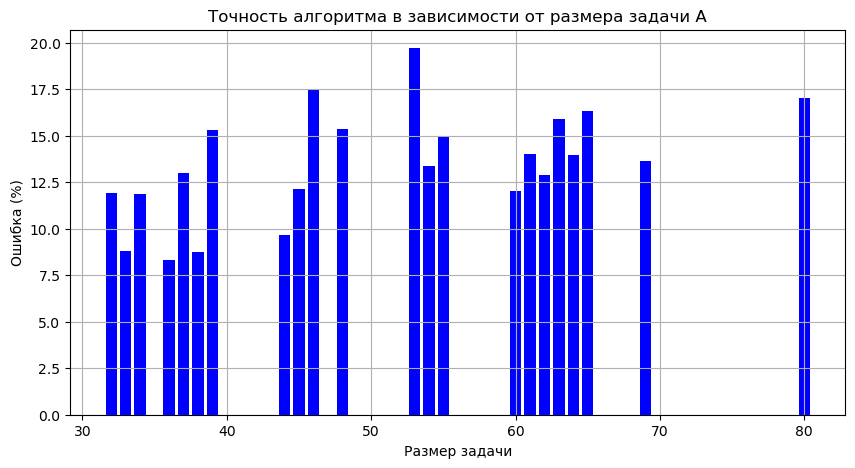

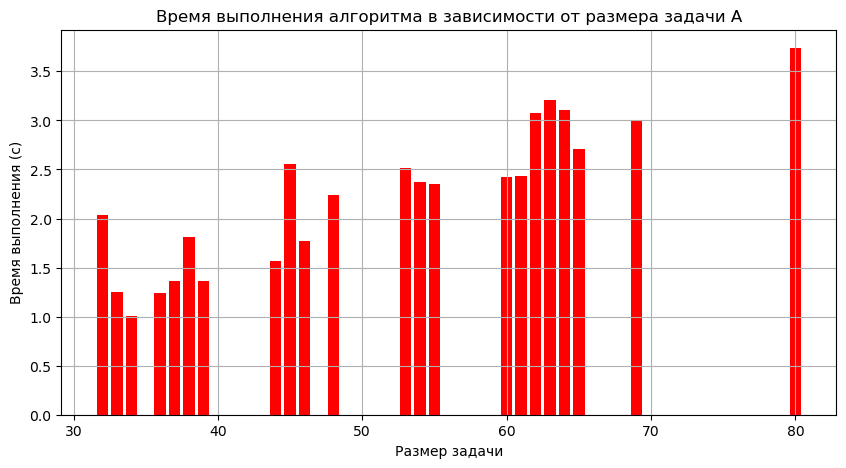

In [467]:
import matplotlib.pyplot as plt
import os
import re

#print(accuracy_array_a,'\n')
#print(sorted(accuracy_array_a))

# Массив для хранения размеров задач
task_sizes_a = []
task_sizes_a.clear()

# Проходимся по файлам в директории
for filename in os.listdir(vrp_folder_a):
    # Используем регулярное выражение для поиска соответствующих файлов и извлечения числа
    match = re.search(r"A-n(\d+)-k\d+\.vrp", filename)
    if match:
        # Преобразуем найденное число в int и добавляем в массив
        task_size = int(match.group(1))
        task_sizes_a.append(task_size)
print("Массив размеров задач:", task_sizes_a)

# График точности в зависимости от размера задачи
plt.figure(figsize=(10, 5))
plt.bar(task_sizes_a, accuracy_array_a, color='b')
plt.title('Точность алгоритма в зависимости от размера задачи А')
plt.xlabel('Размер задачи')
plt.ylabel('Ошибка (%)')
plt.grid(True)
plt.show()

# График времени выполнения в зависимости от размера задачи
plt.figure(figsize=(10, 5))
plt.bar(task_sizes_a, time_array_a, color='r')
plt.title('Время выполнения алгоритма в зависимости от размера задачи А')
plt.xlabel('Размер задачи')
plt.ylabel('Время выполнения (с)')
plt.grid(True)
plt.show()

### Тестирование на B (вывод точности времени выполнения)

In [450]:
average_difference = 0
average_time = 0
accuracy_array_b = []
time_array_b = []
# Цикл по фалам в папке
for i in range(len(vrp_files_b)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_b + vrp_files_b[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        # Добавление значений в массивы
        accuracy_array_b.append(current_difference)
        time_array_b.append(current_time)

        # Обновление средних значений
        average_difference += current_difference
        average_time += current_time

mean_diff_b = average_difference/len(vrp_files_b)
mean_time_b = average_time/len(vrp_files_b)
print(f'Средняя ошибка: {round(mean_diff_b, 2)}%')
print(f'Среднее время расчёта: {round(mean_time_b, 1)}s')

Средняя ошибка: 11.67%
Среднее время расчёта: 1.8s


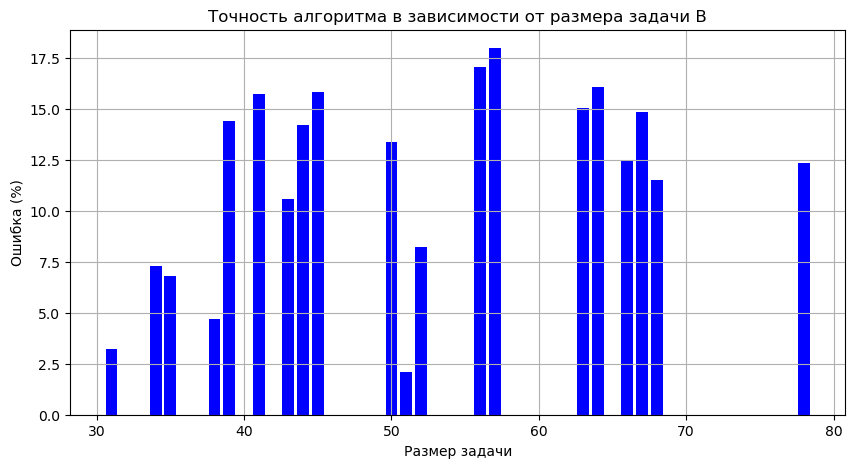

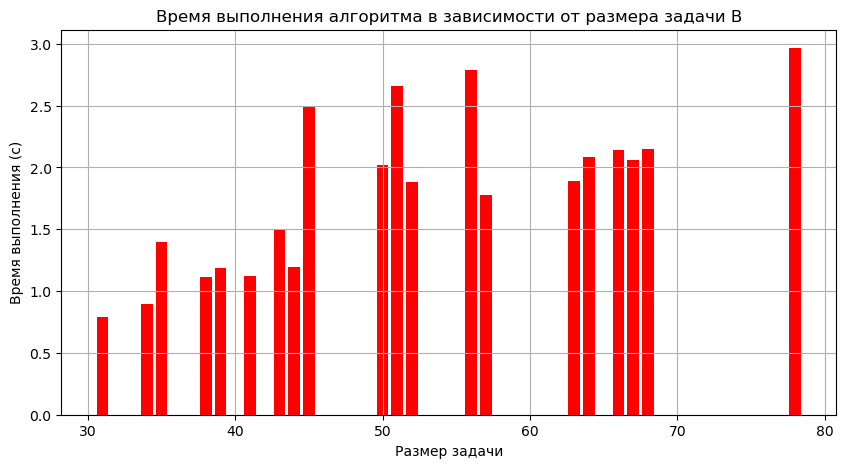

In [468]:
import matplotlib.pyplot as plt
import os
import re

#print(accuracy_array_b,'\n')
#print(sorted(accuracy_array_b))

# Массив для хранения размеров задач
task_sizes_b = []
task_sizes_b.clear()


# Проходимся по файлам в директории
for filename in os.listdir(vrp_folder_b):
    # Используем регулярное выражение для поиска соответствующих файлов и извлечения числа
    match = re.search(r"B-n(\d+)-k\d+\.vrp", filename)
    if match:
        # Преобразуем найденное число в int и добавляем в массив
        task_size = int(match.group(1))
        task_sizes_b.append(task_size)

#print("Массив размеров задач:", task_sizes)

# График точности в зависимости от размера задачи
plt.figure(figsize=(10, 5))
plt.bar(task_sizes_b, accuracy_array_b, color='b')
plt.title('Точность алгоритма в зависимости от размера задачи B')
plt.xlabel('Размер задачи')
plt.ylabel('Ошибка (%)')
plt.grid(True)
plt.show()

# График времени выполнения в зависимости от размера задачи
plt.figure(figsize=(10, 5))
plt.bar(task_sizes_b, time_array_b, color='r')
plt.title('Время выполнения алгоритма в зависимости от размера задачи B')
plt.xlabel('Размер задачи')
plt.ylabel('Время выполнения (с)')
plt.grid(True)
plt.show()

### Тестирование на E (вывод точности времени выполнения)

In [395]:
task_sizes_e = []
task_sizes_e.clear()

# Проходимся по файлам в директории
for filename in os.listdir(vrp_folder_e):
    # Используем регулярное выражение для поиска соответствующих файлов и извлечения числа
    match = re.search(r"E-n(\d+)-k\d+\.vrp", filename)
    if match:
        # Преобразуем найденное число в int и добавляем в массив
        task_size = int(match.group(1))
        task_sizes_e.append(task_size)
print("Массив размеров задач:", task_sizes_e)

Массив размеров задач: [101, 101, 13, 22, 23, 30, 31, 33, 51, 76, 76, 76, 76]


In [396]:
import os
import re

average_difference = 0
average_time = 0
accuracy_array_e = []
time_array_e = []
task_sizes_e2 = []

# Цикл по фалам в папке
for i in range(len(vrp_files_e)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(vrp_folder_e + vrp_files_e[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        task_sizes_e2.append(task_sizes_e[i])
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        # Добавление значений в массивы
        accuracy_array_e.append(current_difference)
        time_array_e.append(current_time)

        # Обновление средних значений
        average_difference += current_difference
        average_time += current_time

mean_diff_e = average_difference/len(vrp_files_e)
mean_time_e = average_time/len(vrp_files_e)
print(f'Средняя ошибка: {round(mean_diff_e, 2)}%')
print(f'Среднее время расчёта: {round(mean_time_e, 1)}s')
print("Массив размеров задач:", task_sizes_e2)

Средняя ошибка: 11.84%
Среднее время расчёта: 2.14s
Массив размеров задач: [101, 101, 22, 23, 30, 33, 51, 76, 76, 76, 76]


[22, 23, 30, 33, 51, 76, 101]


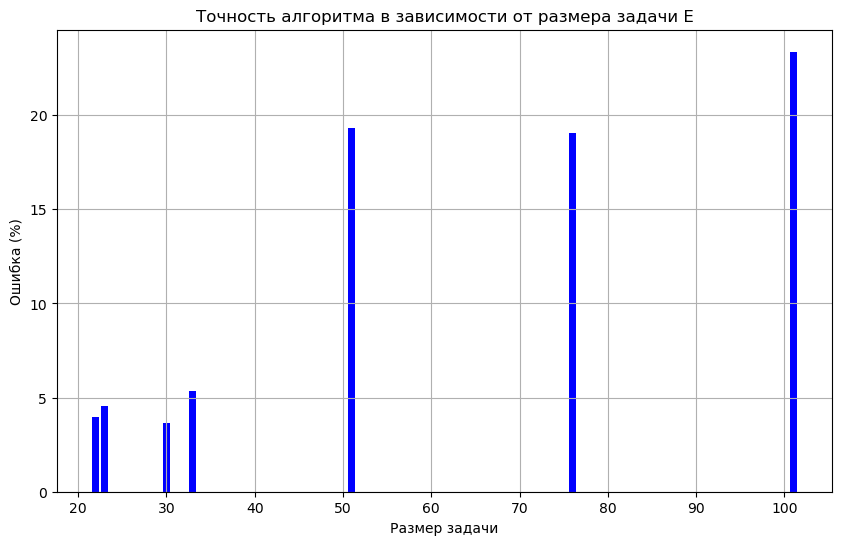

[22, 23, 30, 33, 51, 76, 101]


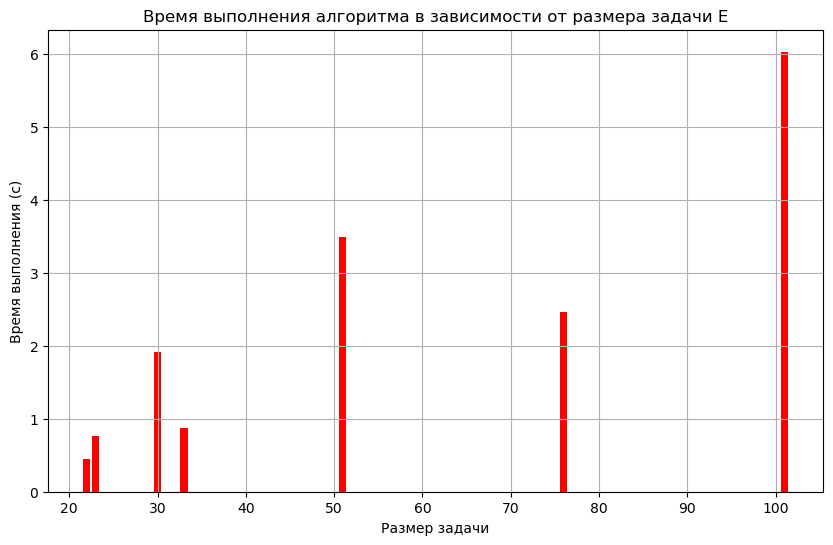

In [469]:
my_dict = {}
for key, value in zip(task_sizes_e2, accuracy_array_e):
    my_dict[key] = value

sorted_keys = sorted(my_dict.keys())
sorted_values = [my_dict[key] for key in sorted_keys]    

print(sorted_keys)

plt.figure(figsize=(10, 6))  # Установка размера графика
plt.bar(sorted_keys, sorted_values, color='b')  # Строим линейный график
plt.title('Точность алгоритма в зависимости от размера задачи E')  # Заголовок графика
plt.xlabel('Размер задачи')  # Подпись оси X
plt.ylabel('Ошибка (%)')  # Подпись оси Y
plt.grid(True)  # Отображение сетки

# Отобразить график
plt.show()

my_dict2 = {}
for key, value in zip(task_sizes_e2, time_array_e):
    my_dict2[key] = value

sorted_keys2 = sorted(my_dict2.keys())
sorted_values2 = [my_dict2[key] for key in sorted_keys2]    

print(sorted_keys2)

plt.figure(figsize=(10, 6))  # Установка размера графика
plt.bar(sorted_keys2, sorted_values2, color='red')  # Строим линейный график
plt.title('Время выполнения алгоритма в зависимости от размера задачи E')  # Заголовок графика
plt.xlabel('Размер задачи')  # Подпись оси X
plt.ylabel('Время выполнения (с)')  # Подпись оси Y
plt.grid(True)  # Отображение сетки

# Отобразить график
plt.show()

### Тестирование на всех наборах (вывод точности времени выполнения)

In [390]:
task_sizes_all = []
task_sizes_all.clear()

# Проходимся по файлам в директории
for filename in os.listdir(all_folder):
    # Используем регулярное выражение для поиска соответствующих файлов и извлечения числа
    match = re.search(r"(A|B|E)-n(\d+)-k\d+\.vrp", filename)
    if match:
        # Преобразуем найденное число в int и добавляем в массив
        task_size = int(match.group(2))
        task_sizes_all.append(task_size)
print("Массив размеров задач:", task_sizes_all)

Массив размеров задач: [32, 33, 33, 34, 36, 37, 37, 38, 39, 39, 44, 45, 45, 46, 48, 53, 54, 55, 60, 61, 62, 63, 63, 64, 65, 69, 80, 31, 34, 35, 38, 39, 41, 43, 44, 45, 45, 50, 50, 51, 52, 56, 57, 57, 63, 64, 66, 67, 68, 78, 101, 101, 13, 22, 23, 30, 31, 33, 51, 76, 76, 76, 76]


In [391]:
average_difference = 0
average_time = 0
accuracy_array_all = []
time_array_all = []
# Цикл по фалам в папке
for i in range(len(vrp_files_all)):
    # Читаем файл vrplib
    vrp_problem = vrplib.read_instance(all_folder + vrp_files_all[i])
    # Парсим содержимое ключа comment
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    # Задаем No_of_trucks и Optimal_value
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    # Проверяем чтобы из файла считались кординаты
    if 'node_coord' in vrp_problem.keys():
        # Задаем класс AntColonyOptimization
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        # Запускаем подсчет
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        # Добавление значений в массивы
        accuracy_array_all.append(current_difference)
        time_array_all.append(current_time)

        # Обновление средних значений
        average_difference += current_difference
        average_time += current_time

mean_diff_all = average_difference/len(vrp_files_all)
mean_time_all = average_time/len(vrp_files_all)
print(f'Средняя ошибка: {round(mean_diff_all, 2)}%')
print(f'Среднее время расчёта: {round(mean_time_all,1)}s')

Average Difference: 11.44%
Average time: 2s


[13, 22, 23, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 48, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 76, 78, 80, 101]


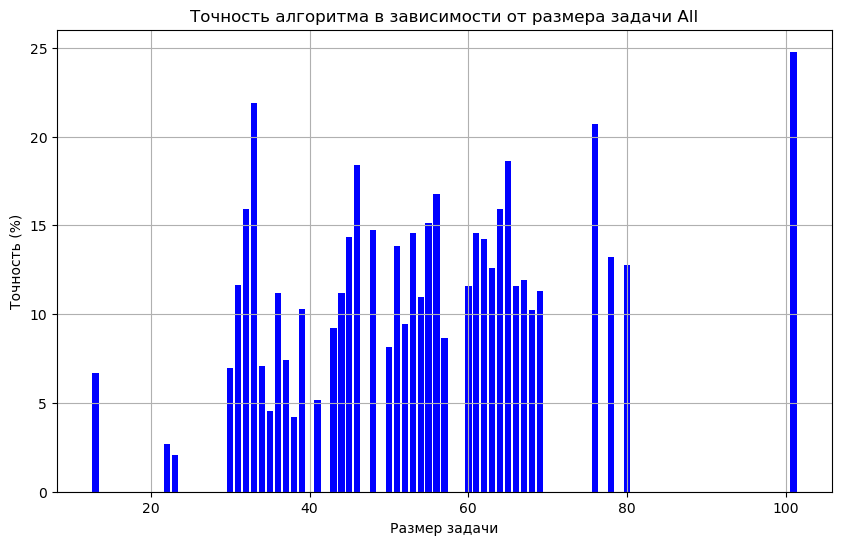

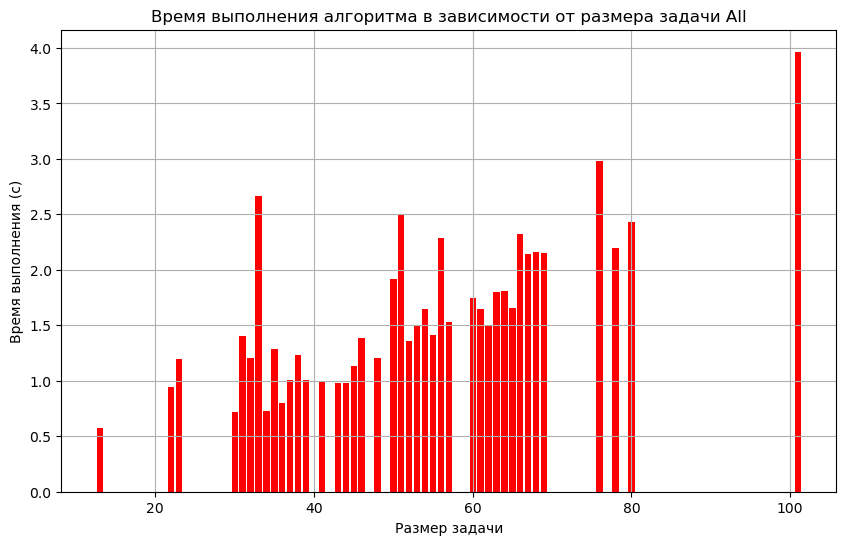

In [392]:
my_dict_all = {}
for key, value in zip(task_sizes_all, accuracy_array_all):
    my_dict_all[key] = value

sorted_keys = sorted(my_dict_all.keys())
sorted_values = [my_dict_all[key] for key in sorted_keys]    

my_dict2 = {}
for key, value in zip(task_sizes_all, time_array_all):
    my_dict2[key] = value

sorted_keys2 = sorted(my_dict2.keys())
sorted_values2 = [my_dict2[key] for key in sorted_keys2]    

print(sorted_keys2)

plt.figure(figsize=(10, 6))  # Установка размера графика
plt.bar(sorted_keys, sorted_values, color='b')  # Строим линейный график
plt.title('Точность алгоритма в зависимости от размера задачи All')  # Заголовок графика
plt.xlabel('Размер задачи')  # Подпись оси X
plt.ylabel('Ошибка (%)')  # Подпись оси Y
plt.grid(True)  # Отображение сетки

plt.figure(figsize=(10, 6))  # Установка размера графика
plt.bar(sorted_keys2, sorted_values2, color='red')  # Строим линейный график
plt.title('Время выполнения алгоритма в зависимости от размера задачи All')  # Заголовок графика
plt.xlabel('Размер задачи')  # Подпись оси X
plt.ylabel('Время выполнения (с)')  # Подпись оси Y
plt.grid(True)  # Отображение сетки

# Отобразить график
plt.show()

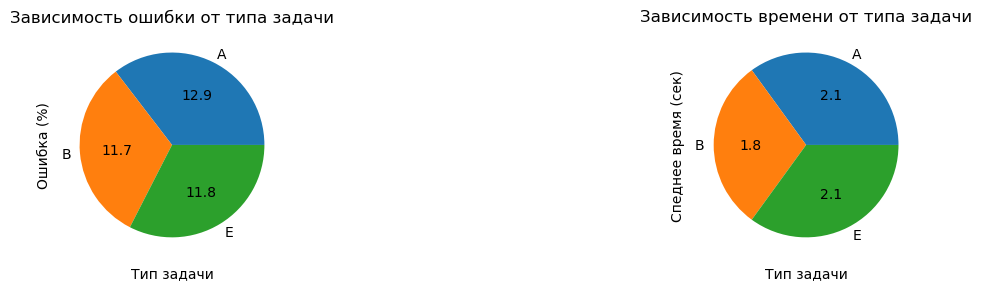

In [466]:

task_types = ['A', 'B', 'E']
#differences = [mean_diff_a, mean_diff_b, mean_diff_e]
differences = [12.89, 11.67, 11.84]
#times = [mean_time_a, mean_time_b, mean_time_e]
times = [2.1, 1.8, 2.1]


def absolute_value(val):
    a = val/100.*sum(differences)
    return "{:.1f}".format(a)

def absolute_value2(val):
    a = val/100.*sum(times)
    return "{:.1f}".format(a)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.pie(differences, labels = task_types, autopct=absolute_value)
ax1.set_xlabel('Тип задачи')
ax1.set_ylabel('Ошибка (%)')
ax1.set_title('Зависимость ошибки от типа задачи')

ax2.pie(times, labels = task_types, autopct=absolute_value2)
ax2.set_xlabel('Тип задачи')
ax2.set_ylabel('Спеднее время (сек)')
ax2.set_title('Зависимость времени от типа задачи')

plt.show()